In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# Fazer um treinamento de baseline, e para o teste aplicar intervenções:
# verificar influencia de cor, testar com as imagens com cor única; [DONE]
# verificar influencia de formato das lesões, não sei se é muito complexo fazer isso, mas daria para modificar um pouco a borda das imagens/aumentar tamanho da lesão;
# verificar influencia de artefatos
# verificar influencia da rotação, escala, (brilho, contraste e saturação - DONE)
# verificar influencia de ruidos [DONE]
# segmentação apenas da lesão  [DONE]
# verificação da influencia de textura [DONE]


In [3]:
# glob.glob('../../data/isic/isic2018/*')

In [4]:
files = glob.glob('../../data/isic/isic2018/ISIC2018_Task1-2_Training_Input/*')

In [5]:
aux = 0
imagem = cv2.imread(files[aux])
mask = glob.glob('../../data/isic/isic2018/ISIC2018_Task1_Training_GroundTruth/*_{}_*'.format(files[aux].split('ISIC_')[-1].split('.jpg')[0]))


In [6]:
imagem.shape

(2000, 3008, 3)

In [7]:
mask

['../../data/isic/isic2018/ISIC2018_Task1_Training_GroundTruth/ISIC_0012178_segmentation.png']

In [8]:
segmentation_mask =  cv2.imread(mask[0], cv2.IMREAD_GRAYSCALE)  / 255.0
# _, segmentation_mask = cv2.threshold(segmentation_mask, thresh=180, maxval=255, type=cv2.THRESH_BINARY)

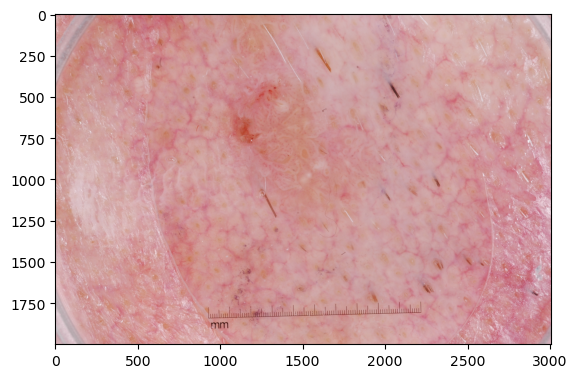

In [9]:
plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))

### Color Change and transparency

In [10]:
def change_hue_value(image, segmentation_mask, color=[0,0,255], alpha=.8):
    image_color = np.copy(image)
    image_color[(segmentation_mask==1.0)] = [0,0,255]
    image_color_w = cv2.addWeighted(image_color, 1-alpha, image, alpha, 0, image_color)
        
    return image_color_w.astype(np.uint8)
    
    
    

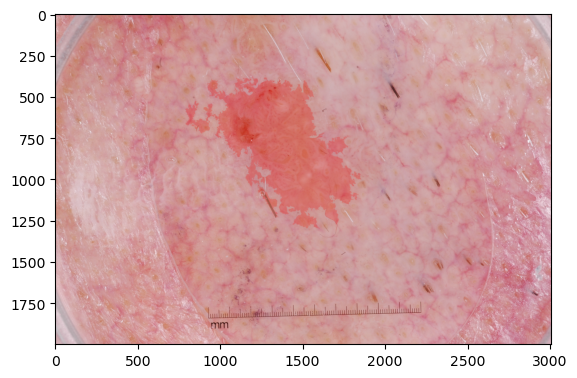

In [11]:
plt.imshow(cv2.cvtColor(change_hue_value(imagem, segmentation_mask, color=[0,0,255], alpha=0.8), cv2.COLOR_BGR2RGB))

### Brightness

In [12]:
def change_brightness_value(image, mask,  value=30):
    ## value only can assume < 255
    img = np.copy(image)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[(v > lim) & (mask==1.0)] = 255
    v[(v <= lim) & (mask==1.0)] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img.astype(np.uint8)

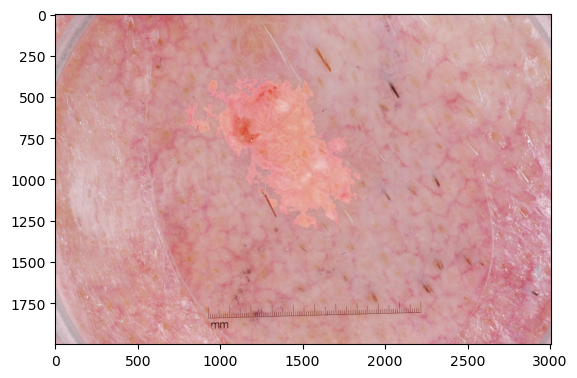

In [13]:
plt.imshow(cv2.cvtColor(change_brightness_value(imagem, segmentation_mask, value=30), cv2.COLOR_BGR2RGB))

### Contrast

In [14]:
def change_contrast_value(img, mask, alpha=1.5, beta=0):
    # Contrast control (1.0-3.0)
    0 # Brightness control (0-100)
    image = np.copy(img)
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    image = image + (adjusted * mask.reshape(mask.shape[0],mask.shape[1] ,1))
    
    return image.astype(np.uint8)

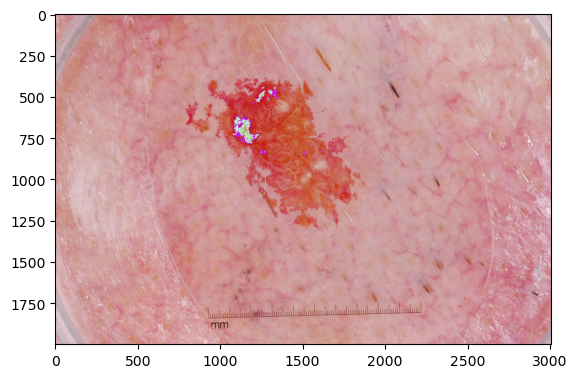

In [15]:
plt.imshow(cv2.cvtColor(change_contrast_value(imagem, segmentation_mask, alpha=1.5, beta=0), cv2.COLOR_BGR2RGB))

### Texture

In [16]:
def change_texture(img, texture, mask, alpha=0.8):
    image = np.copy(img)
    texture_resized = cv2.resize(texture, (image.shape[1], image.shape[0]))
    result_image = np.copy(imagem)
    result_image = result_image * (1 - mask.reshape(mask.shape[0],mask.shape[1] ,1)) + (texture_resized * mask.reshape(mask.shape[0],mask.shape[1] ,1))
    result_image = cv2.addWeighted(result_image.astype(np.uint8), 1-alpha, img, alpha, 0, result_image.astype(np.uint8))
    return result_image.astype(np.uint8)

In [17]:
# def change_texture(img, texture, mask):
texture_path = '../../data/Splited/train/KTH_aluminium_foil/1.jpg'
texture = cv2.imread(texture_path)
texture_rgb = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)

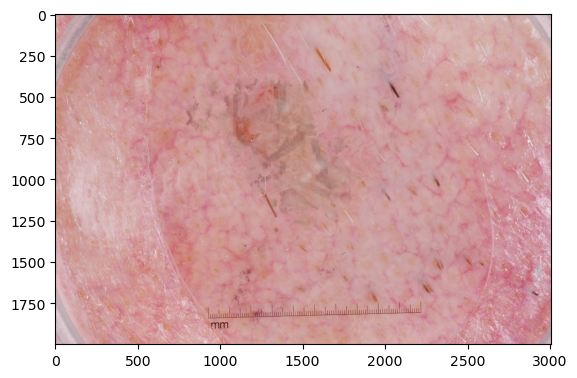

In [18]:
plt.imshow(cv2.cvtColor(change_texture(imagem, texture, segmentation_mask), cv2.COLOR_BGR2RGB))

### Noise

In [19]:
def add_noise(img, mask, scale=80):
    image = np.copy(img)
    noise = np.random.normal(loc=0, scale=scale, size=image.shape)
    
    image[mask==1] += noise[mask==1].astype('uint8')
    return image.astype('uint8')

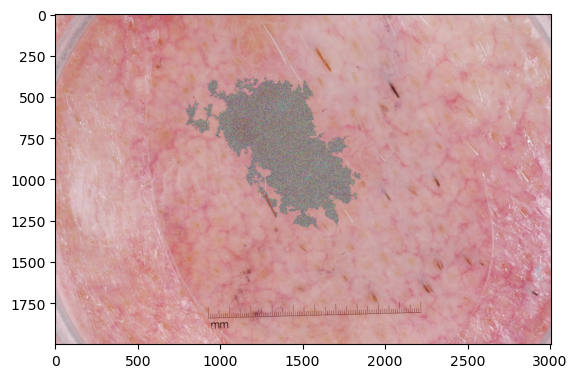

In [20]:
plt.imshow(cv2.cvtColor(add_noise(imagem, segmentation_mask, scale=80), cv2.COLOR_BGR2RGB))

### Crop Mask Region

In [21]:
def crop_mask_region(img, mask):
    x, y, w, h = cv2.boundingRect(mask.astype(np.uint8))
    exp_mask = np.zeros_like(img[:, :, 0])
    exp_mask[y:y+h, x:x+w] = 1
    box_image = img * exp_mask[:, :, np.newaxis]
    
    return box_image


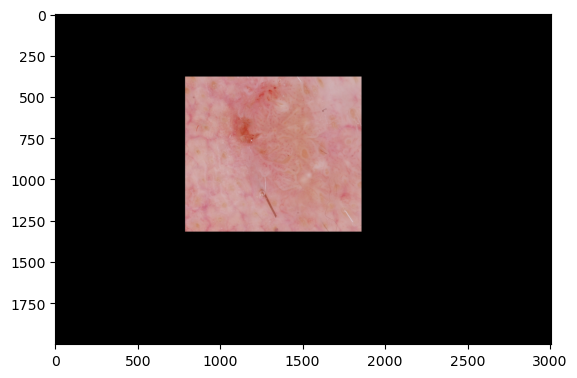

In [22]:
plt.imshow(cv2.cvtColor(crop_mask_region(imagem, segmentation_mask), cv2.COLOR_BGR2RGB))

In [23]:
imagem_cp = np.copy(imagem)
imagem_cinza = cv2.cvtColor(imagem_cp, cv2.COLOR_BGR2GRAY)

bordas = cv2.Canny(imagem_cinza, 50, 150)

# Encontrar contornos na imagem
contornos, _ = cv2.findContours(bordas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Encontrar o contorno que representa a régua (assumindo que a régua é o maior contorno)
maior_contorno = max(contornos, key=cv2.contourArea)

# Encontrar as coordenadas do retângulo delimitador da régua
#for i in contornos:
 #   x, y, largura, altura = cv2.boundingRect(i)
#
    # Cobrir a régua com um quadrado preto na imagem original
 #   imagem_com_quadrado_preto = imagem_cp.copy()
  #  plt.imshow(cv2.cvtColor(cv2.rectangle(imagem_com_quadrado_preto, (x, y), (x + largura, y + altura), (0, 0, 0), -1), cv2.COLOR_BGR2RGB))


In [25]:
contornos[0]

array([[[2520, 1998]],

       [[2520, 1999]],

       [[2521, 1998]],

       [[2522, 1999]],

       [[2523, 1999]],

       [[2522, 1998]]], dtype=int32)

In [29]:
imagem_com_quadrado_preto = imagem.copy()

for i in contornos[0:3]:
    x, y, largura, altura = cv2.boundingRect(i)
    
    imagem_com_quadrado_preto += cv2.rectangle(imagem_com_quadrado_preto, (x, y), (x + largura, y + altura), (0, 0, 0), -1)

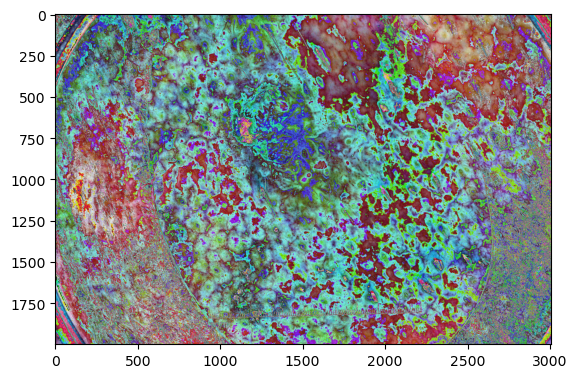

In [30]:
plt.imshow(cv2.cvtColor(imagem_com_quadrado_preto, cv2.COLOR_BGR2RGB))
